In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random, jit

In [2]:
import dmeq

In [3]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
import arviz as az

In [4]:
n_chains = 10
numpyro.set_host_device_count(n_chains)

In [5]:
seed = random.PRNGKey(42)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
def prev_stats(params, eir):
    p = dmeq.default_parameters()
    (
        p['kb'],
        p['ub'],
        p['b0'],
        p['IB0'],
        p['kc'],
        p['uc'],
        p['IC0'],
        p['phi0'],
        p['phi1'],
        p['PM'],
        p['dm'],
        #p['kd'],
        #p['ud'],
        #p['d1'],
        #p['ID0'],
        #p['fd0'],
        #p['gd'],
        #p['ad0'],
        #p['du']
    )= params
    p['EIR'] = eir
    solution = dmeq.solve(p, dtype=jnp.float64)
    return jnp.array([
        solution[0, 3:10].sum() / solution[2, 3:10].sum(), # Prev 2 - 10
        solution[0, 10:].sum() / solution[2, 10:].sum(), # Prev 10+
        solution[1, :5].sum() / solution[2, :5].sum(), # Inc 0 - 5
        solution[1, 5:15].sum() / solution[2, 5:15].sum(), # Inc 5 - 15
        solution[1, 15:].sum() / solution[2, 15:].sum() # Inc 15+
    ])

In [7]:
population = 100_000
EIR = 21.

In [8]:
def model(prev=None):
    # Pre-erythrocytic immunity
    kb = numpyro.sample('kb', dist.Gamma(2., 1.))
    ub = numpyro.sample('ub', dist.Gamma(5., 1.))
    b0 = numpyro.sample('b0', dist.Beta(1., 1.))
    IB0 = numpyro.sample('IB0', dist.LeftTruncatedDistribution(dist.Normal(50., 10.), low=0.))
    
    # Clinical immunity
    kc = numpyro.sample('kc', dist.Gamma(2., 1.))
    uc = numpyro.sample('uc', dist.Gamma(5., 1.))
    phi0 = numpyro.sample('phi0', dist.Beta(5., 1.))
    phi1 = numpyro.sample('phi1', dist.Beta(1., 2.))
    IC0 = numpyro.sample('IC0', dist.LeftTruncatedDistribution(dist.Normal(100., 10.), low=0.))
    PM = numpyro.sample('PM', dist.Beta(1., 1.))
    dm = numpyro.sample('dm', dist.LeftTruncatedDistribution(dist.Normal(200., 10.), low=0.))
    
    # Detection immunity
    #kd = numpyro.sample('kd', dist.Gamma(2., 1))
    #ud = numpyro.sample('ud', dist.Gamma(5., 1.))
    #d1 = numpyro.sample('d1', dist.Beta(1., 2.))
    #ID0 = numpyro.sample('ID0', dist.LeftTruncatedDistribution(dist.Normal(25., 1.), low=0.))
    #fd0 = numpyro.sample('fd0', dist.Beta(0., 1.))
    #gd = numpyro.sample('gd', dist.Gamma(1., 1.))
    #ad0 = numpyro.sample('ad0', dist.Gamma(10., 1.))
    
    #du = numpyro.sample('du', dist.LeftTruncatedDistribution(dist.Normal(50., 1.), low=0.))
    
    # FOIM
    # cd
    # cu
    # gamma1
    
    
    pred_prev = prev_stats([
        kb,
        ub,
        b0,
        IB0,
        kc,
        uc,
        IC0,
        phi0,
        phi1,
        PM,
        dm,
        #kd,
        #ud,
        #d1,
        #ID0,
        #fd0,
        #gd,
        #ad0,
        #du
    ], EIR)
    numpyro.sample(
        'obs',
        dist.Independent(
            dist.Binomial(population, pred_prev),
            1
        ),
        obs=prev
    )

In [9]:
true_values = Predictive(model, num_samples=1)(seed)

In [10]:
true_values

{'IB0': Array([55.93777004], dtype=float64),
 'IC0': Array([94.55753044], dtype=float64),
 'PM': Array([0.61014955], dtype=float64),
 'b0': Array([0.35407383], dtype=float64),
 'dm': Array([201.62779889], dtype=float64),
 'kb': Array([1.19891994], dtype=float64),
 'kc': Array([1.54355741], dtype=float64),
 'obs': Array([[38857, 24080,   422,   600,   552]], dtype=int64),
 'phi0': Array([0.88068824], dtype=float64),
 'phi1': Array([0.20328874], dtype=float64),
 'ub': Array([2.71253897], dtype=float64),
 'uc': Array([7.92831917], dtype=float64)}

In [11]:
observations = true_values['obs'][0]

In [12]:
observations

Array([38857, 24080,   422,   600,   552], dtype=int64)

In [13]:
n_samples = 100
n_warmup = 100

mcmc = MCMC(
    NUTS(model),
    num_samples=n_samples,
    num_warmup=n_warmup,
    num_chains=n_chains,
)
mcmc.run(seed, observations)
mcmc.print_summary(prob=0.7)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

2023-01-16 14:29:23.525240: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module pmap__unnamed_wrapped_function_] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-01-16 14:30:20.618723: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 2m57.093662624s

********************************
[Compiling module pmap__unnamed_wrapped_function_] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************



                mean       std    median     15.0%     85.0%     n_eff     r_hat
       IB0     52.20      9.76     52.29     42.02     62.30    803.70      1.00
       IC0     99.67     10.18     99.47     88.59    109.52    760.91      1.00
        PM      0.50      0.29      0.51      0.29      0.98    870.43      1.01
        b0      0.36      0.01      0.36      0.35      0.38    573.62      1.01
        dm    199.73     10.04    200.07    189.43    209.14   1074.57      1.00
        kb      1.21      0.41      1.16      0.73      1.44    792.48      1.00
        kc      1.53      1.02      1.21      0.50      1.68    385.58      1.03
      phi0      0.86      0.07      0.86      0.77      0.93    292.48      1.05
      phi1      0.23      0.12      0.22      0.08      0.35    407.58      1.02
        ub      4.97      2.27      4.61      2.48      6.77    783.05      1.00
        uc      4.88      2.24      4.57      2.45      6.56    778.39      1.00

Number of divergences: 0


In [14]:
prior = Predictive(model, num_samples=600)(seed)

In [15]:
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(seed, observations)

In [16]:
pyro_data = az.from_numpyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive
)

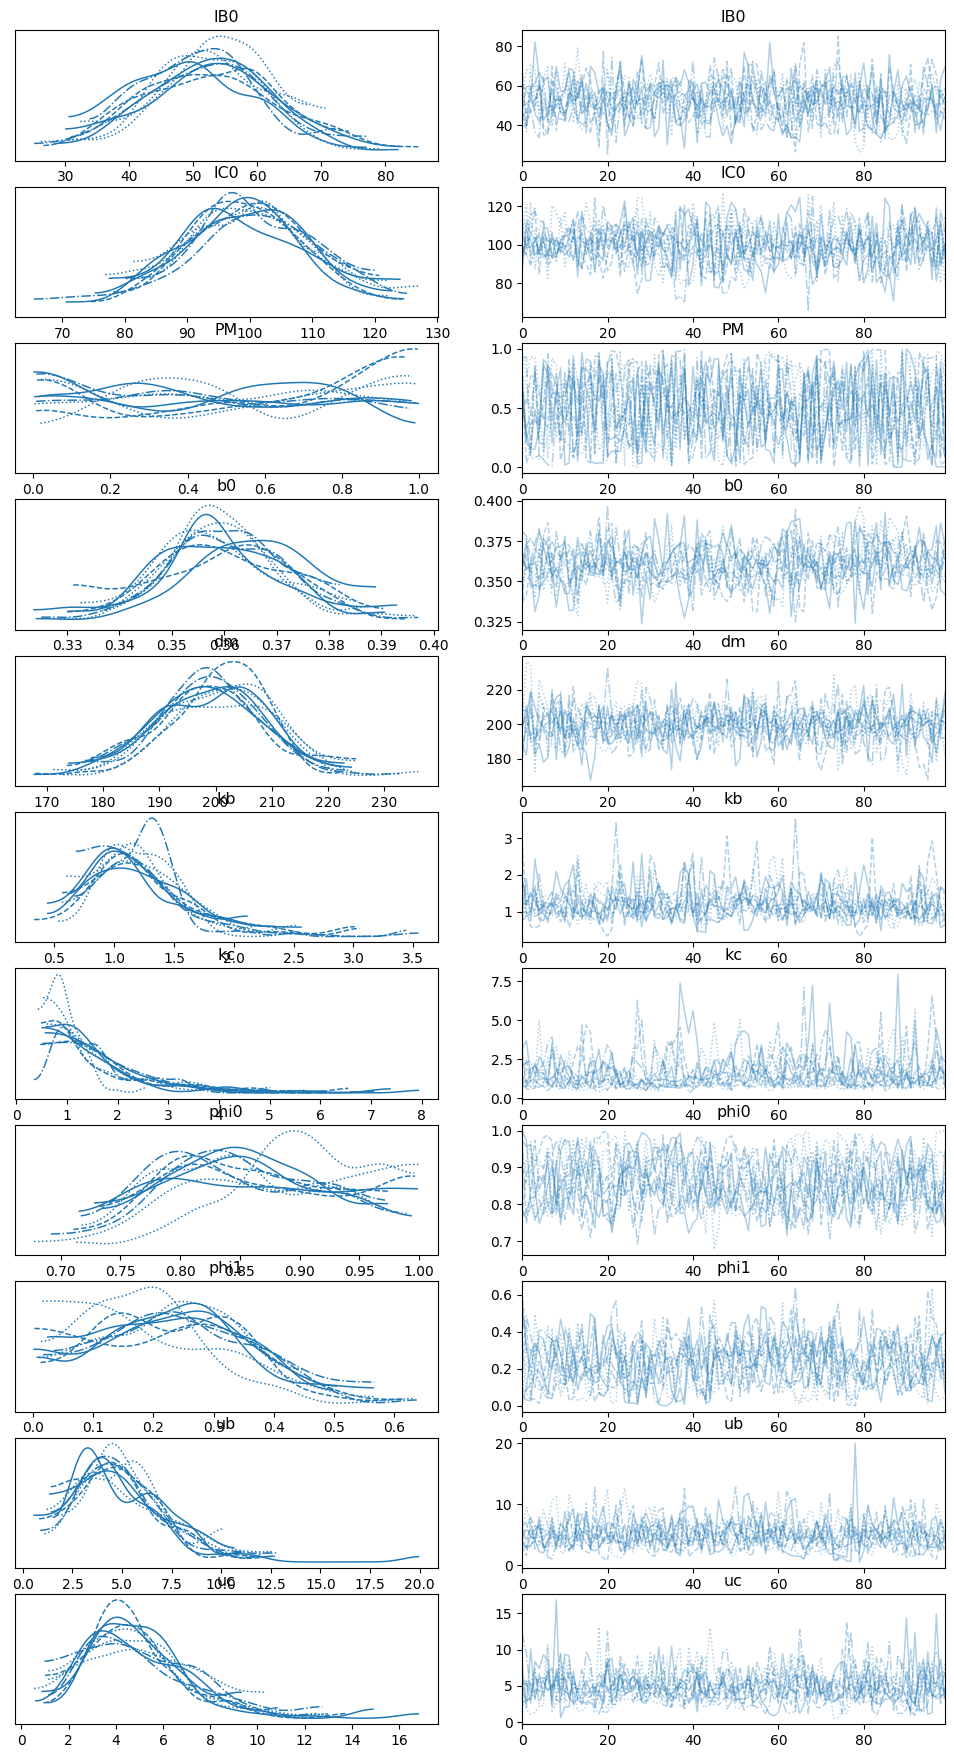

In [17]:
axs = az.plot_trace(pyro_data)

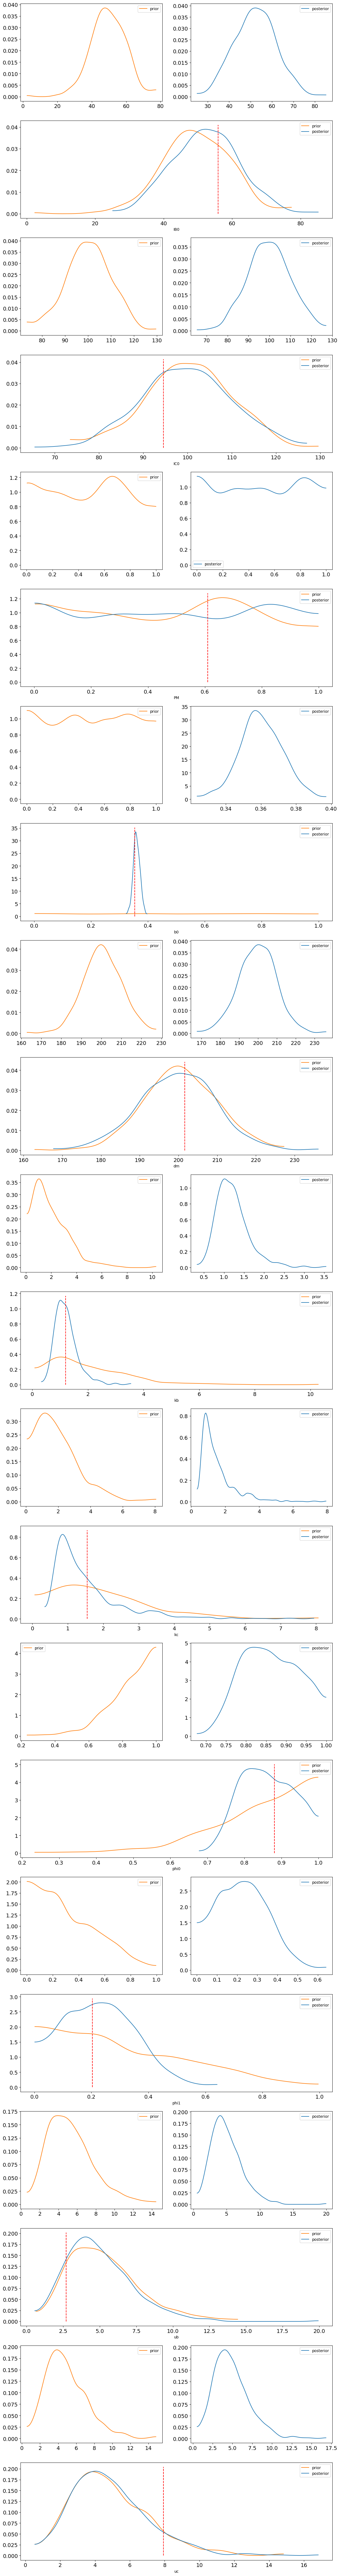

In [18]:
axs = az.plot_dist_comparison(pyro_data)
keys = list(pyro_data.prior.data_vars.keys())
for i in range(axs.shape[0]):
    axs[i, 2].vlines(
        true_values[keys[i]][0],
        0,
        axs[i, 2].get_ylim()[1],
        color = 'red',
        linestyle = 'dashed'
    )